In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import MobileNetV2
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.utils import image_dataset_from_directory

from keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [6]:
train_dir = "/kaggle/input/signlanguagetransl/asl_alphabet_train/asl_alphabet_train"
test_dir  = "/kaggle/input/signlanguagetransl/asl_alphabet_test/asl_alphabet_test"
# Load training dataset
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    seed=42,
    subset="training"
)

validation_ds = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    seed=42,
    subset="validation"
)



# Normalization layer: divides pixel values by 255
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to datasets
train = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation = validation_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


I0000 00:00:1756910126.129078      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756910126.129936      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [7]:
conv_base = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [9]:
conv_base.trainable = True
for layer in conv_base.layers[:-30]:  # Freeze all but last 30 layers
    layer.trainable = False

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
], name="data_augmentation")

model = Sequential()
model.add(data_augmentation)
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(len(train_ds.class_names), activation = "softmax", dtype = "float32"))

model.compile(optimizer=RMSprop(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,526,400 (5.82 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [11]:
history = model.fit(train, epochs = 5, validation_data = validation)

Epoch 1/5


I0000 00:00:1756910162.600428     140 cuda_dnn.cc:529] Loaded cuDNN version 90300


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 206s 87ms/step - accuracy: 0.3779 - loss: 2.3581 - val_accuracy: 0.9420 - val_loss: 0.2560
Epoch 2/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 161s 74ms/step - accuracy: 0.9044 - loss: 0.3643 - val_accuracy: 0.9816 - val_loss: 0.0883
Epoch 3/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 161s 74ms/step - accuracy: 0.9547 - loss: 0.1663 - val_accuracy: 0.9898 - val_loss: 0.0474
Epoch 4/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 161s 74ms/step - accuracy: 0.9718 - loss: 0.1000 - val_accuracy: 0.9926 - val_loss: 0.0300
Epoch 5/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 161s 74ms/step - accuracy: 0.9812 - loss: 0.0667 - val_accuracy: 0.9948 - val_loss: 0.0215


In [12]:
loss, accuracy = model.evaluate(validation)
print(f"validation Loss : ", loss)
print(f"Validation Accuracy : ", accuracy)

544/544 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.9951 - loss: 0.0213
validation Loss :  0.021491285413503647
Validation Accuracy :  0.9948275685310364


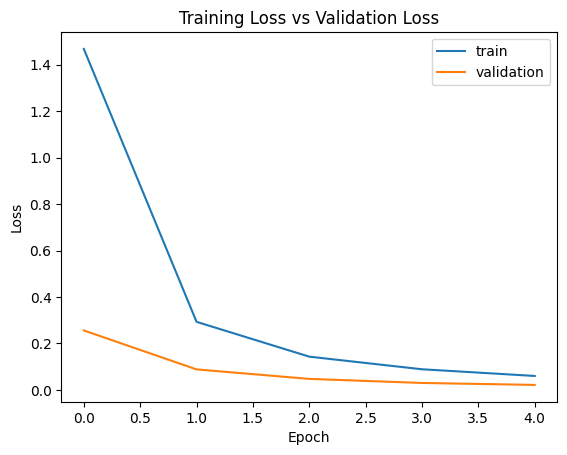

In [13]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "validation")
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

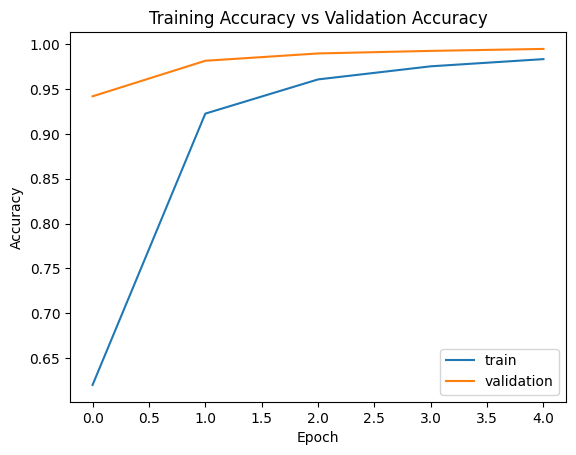

In [14]:
plt.plot(history.history["accuracy"], label = "train")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [15]:
# Save the Model
model.save("model.keras")

In [18]:
model.save("model.h5")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=asl_model_saved.

In [17]:
import json
with open("asl_labels.json", "w") as f:
    json.dump(dict(enumerate(train_ds.class_names)), f)

In [19]:
loaded = tf.keras.models.load_model("model.keras", safe_mode=False)

# Take only the first input branch
inp = loaded.inputs[0]
out = loaded.outputs[0]

# Rebuild as single-input model
fixed_model = tf.keras.Model(inputs=inp, outputs=out)
fixed_model.save("model_fixed.keras")